In [1]:
import networkx as nx
import numpy as np
from scipy import ndimage as nd

In [2]:
def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    return 0.0

def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint, mode='nearest', extra_arguments=(g,))
    
    return g

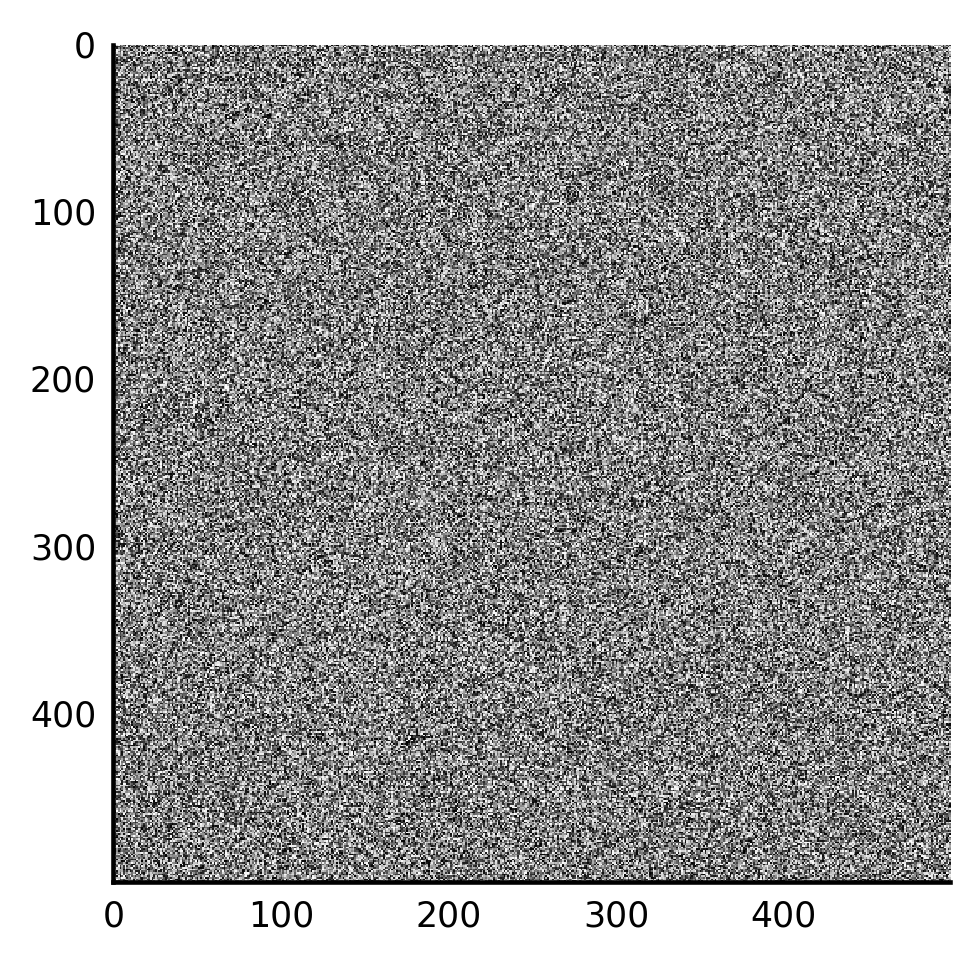

In [2]:
# Make a white noise image:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

import numpy as np
random_image = np.random.rand(500, 500)
plt.imshow(random_image);

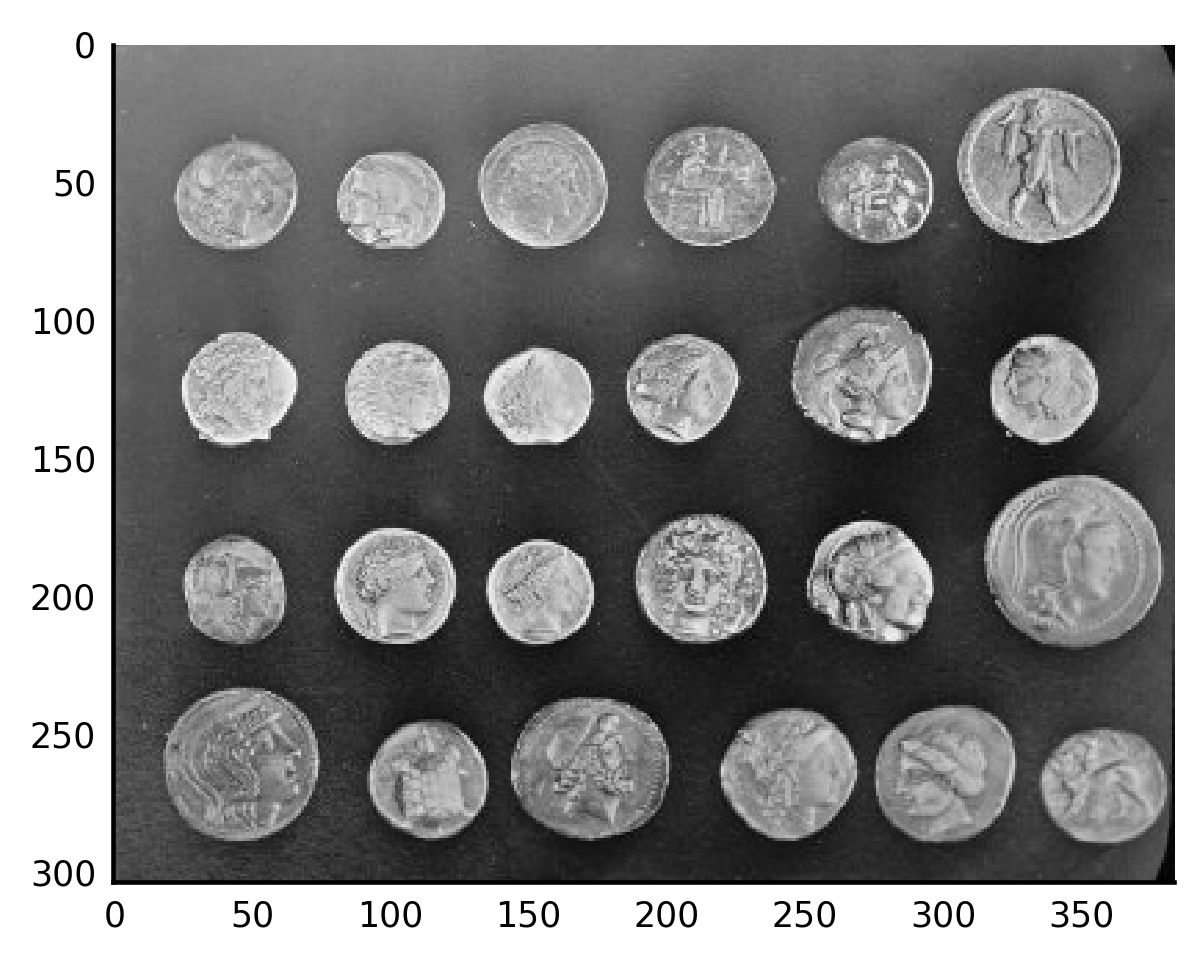

In [3]:
from skimage import io
url_coins = ('https://raw.githubusercontent.com/scikit-image/scikit-image/v0.10.1/skimage/data/coins.png')
coins = io.imread(url_coins)
#print("Type: {} Shape: {} Data type: {}".format(type(coins), coins.shape, coins.dtype))
plt.imshow(coins)

Type: <class 'numpy.ndarray'> Shape: (512, 512, 3) Data type: uint8


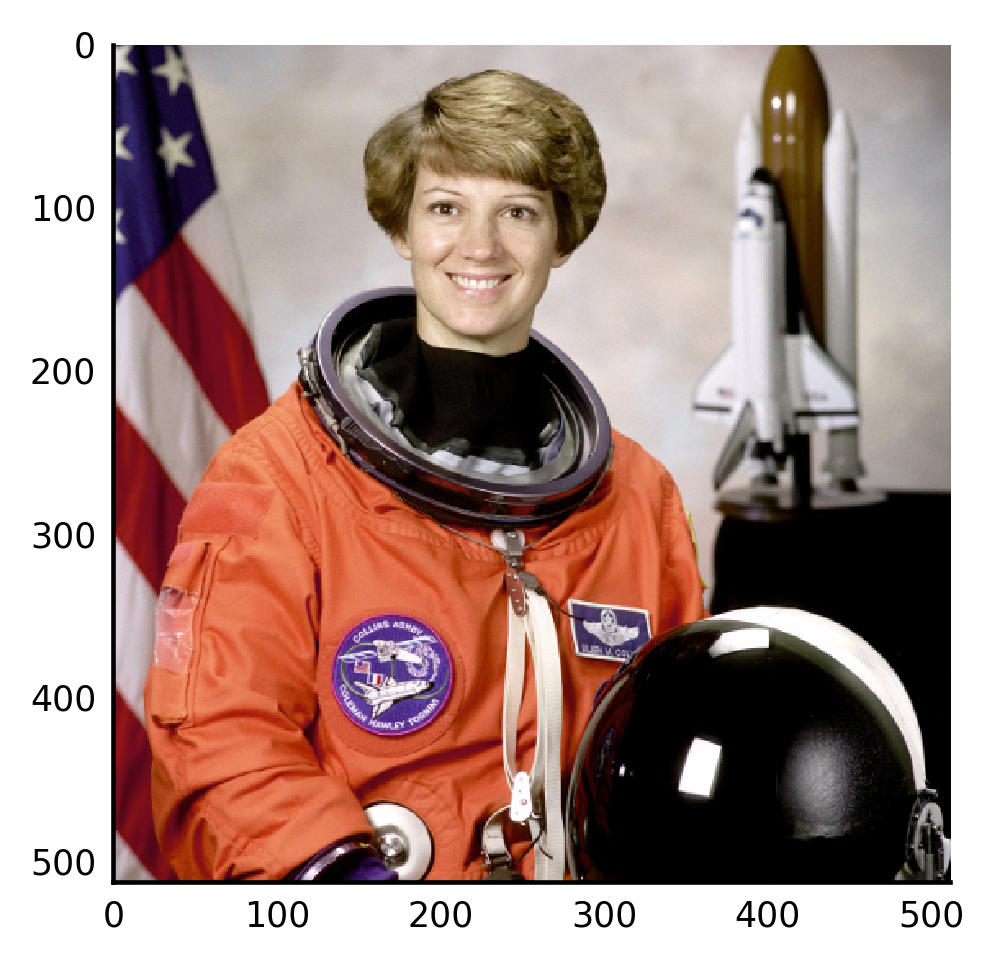

In [8]:
# Play with "3-D" color image

url_astronaut = ('https://raw.githubusercontent.com/scikit-image/scikit-image/master/skimage/data/astronaut.png')
astro = io.imread(url_astronaut)
print("Type: {} Shape: {} Data type: {}".format(type(astro), astro.shape, astro.dtype))
plt.imshow(astro);

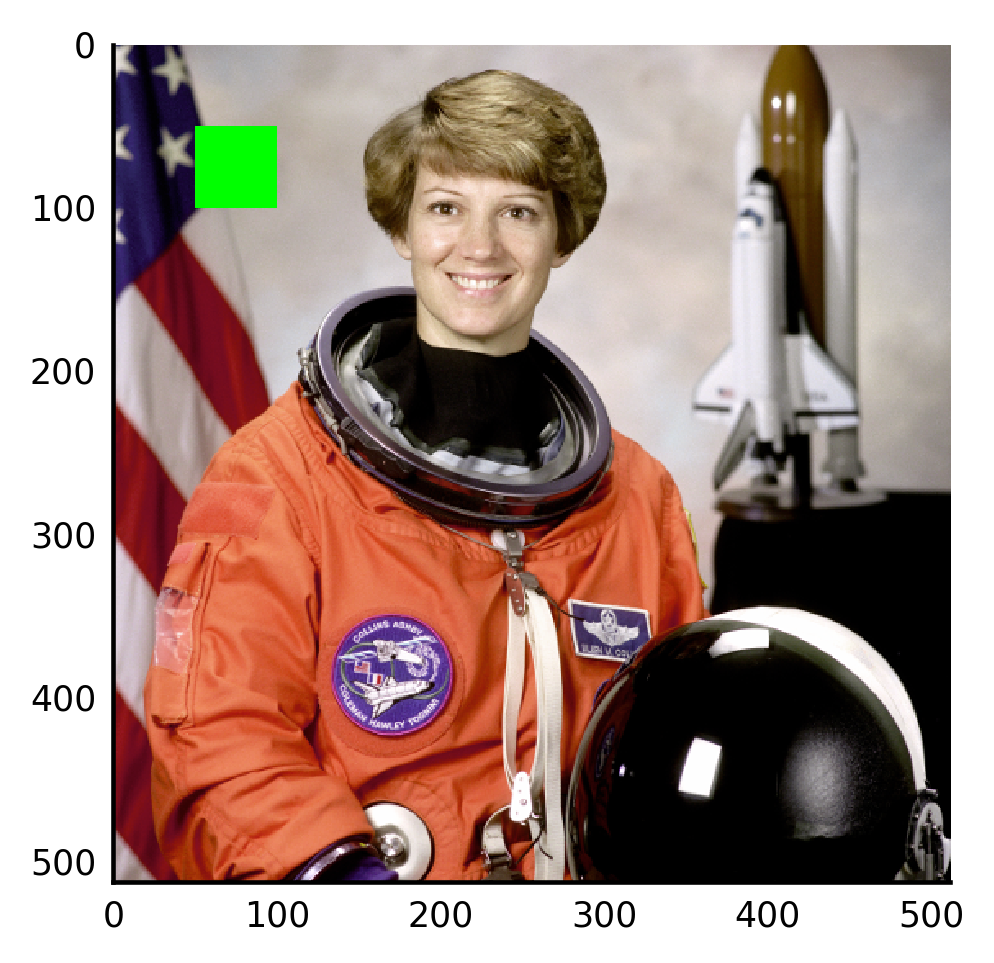

In [9]:
# Add a green square
astro_sq = np.copy(astro)
astro_sq[50:100, 50:100] = [0, 255, 0] # red, green, blue
plt.imshow(astro_sq);

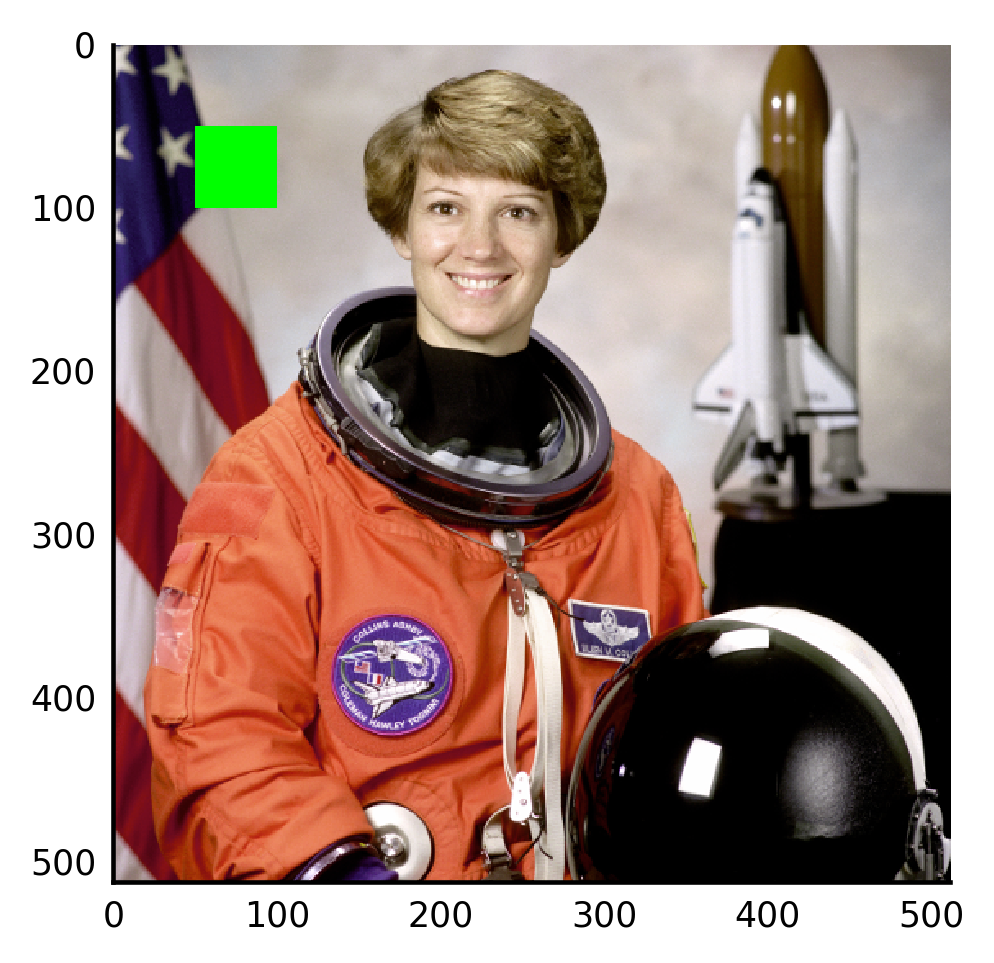

In [10]:
# Boolean mask
astro_sq = np.copy(astro)
sq_mask = np.zeros(astro.shape[:2], bool)
sq_mask[50:100, 50:100] = True
astro_sq[sq_mask] = [0, 255, 0]
plt.imshow(astro_sq);

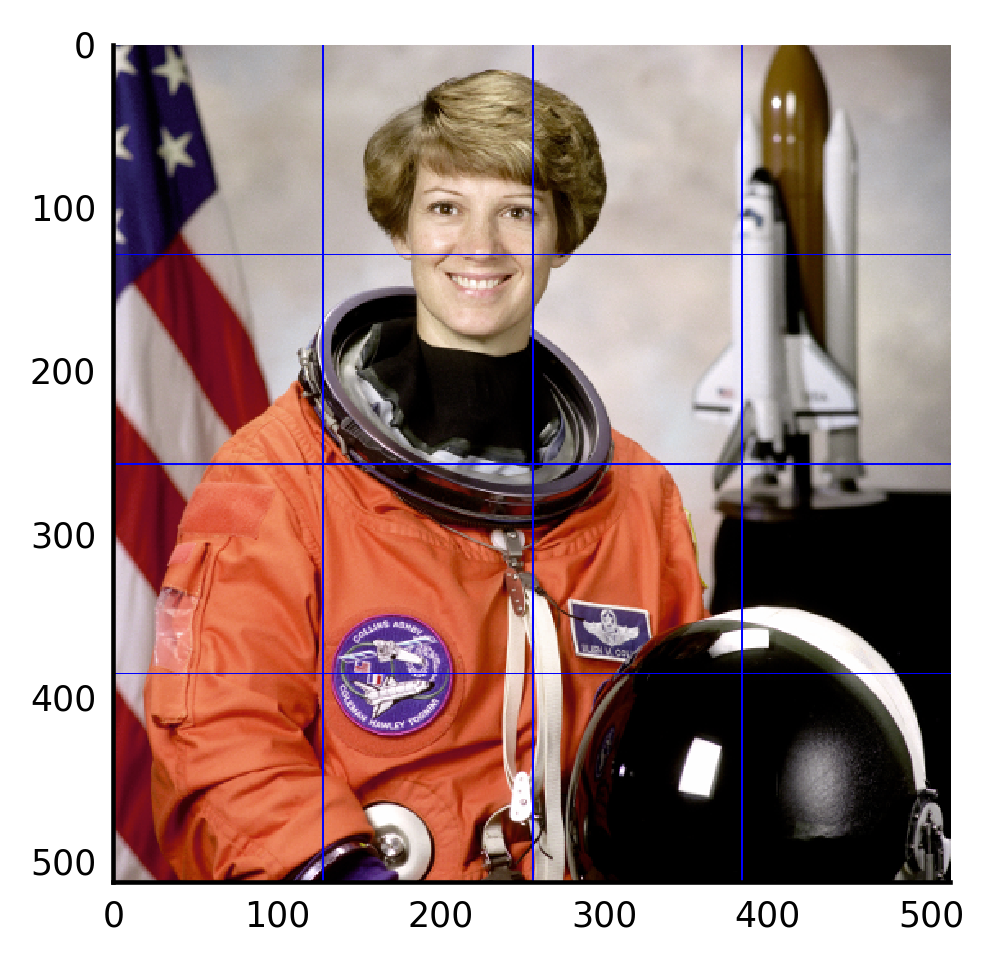

In [34]:
def overlay_grid(image, spacing=128):
    """ Return an image with a grid overlay, using the provided spacing.
    
    Parameters
    ----------
    image : array, shape(M, N, 3)
        The input image.
    space : int
        Spacing between grid lines.
        
    Returns
    -------
    image_gridded : array, shape(M, N, 3)
    """
    image_gridded = image.copy()
    
    # Horizontal
    image_gridded[spacing:-1:spacing, :] = [0, 0, 255]
    # Vertical
    image_gridded[:, spacing:-1:spacing] = [0, 0, 255]
    
    """
    # Vertical stripes
    for row in range(image.shape[0]-1):
        if row % spacing == 0: 
            image_gridded[0:image.shape[0]-1, row:row+1] = [0, 0, 255]
    
    # Horizontal stripes
    for col in range(image.shape[1]-1):
        if col % spacing == 0: 
            image_gridded[col:col+1, 0:image.shape[0]-1] = [0, 0, 255]
    """
    
    return image_gridded

plt.imshow(overlay_grid(astro, 128));
    

(-0.1, 1.1)

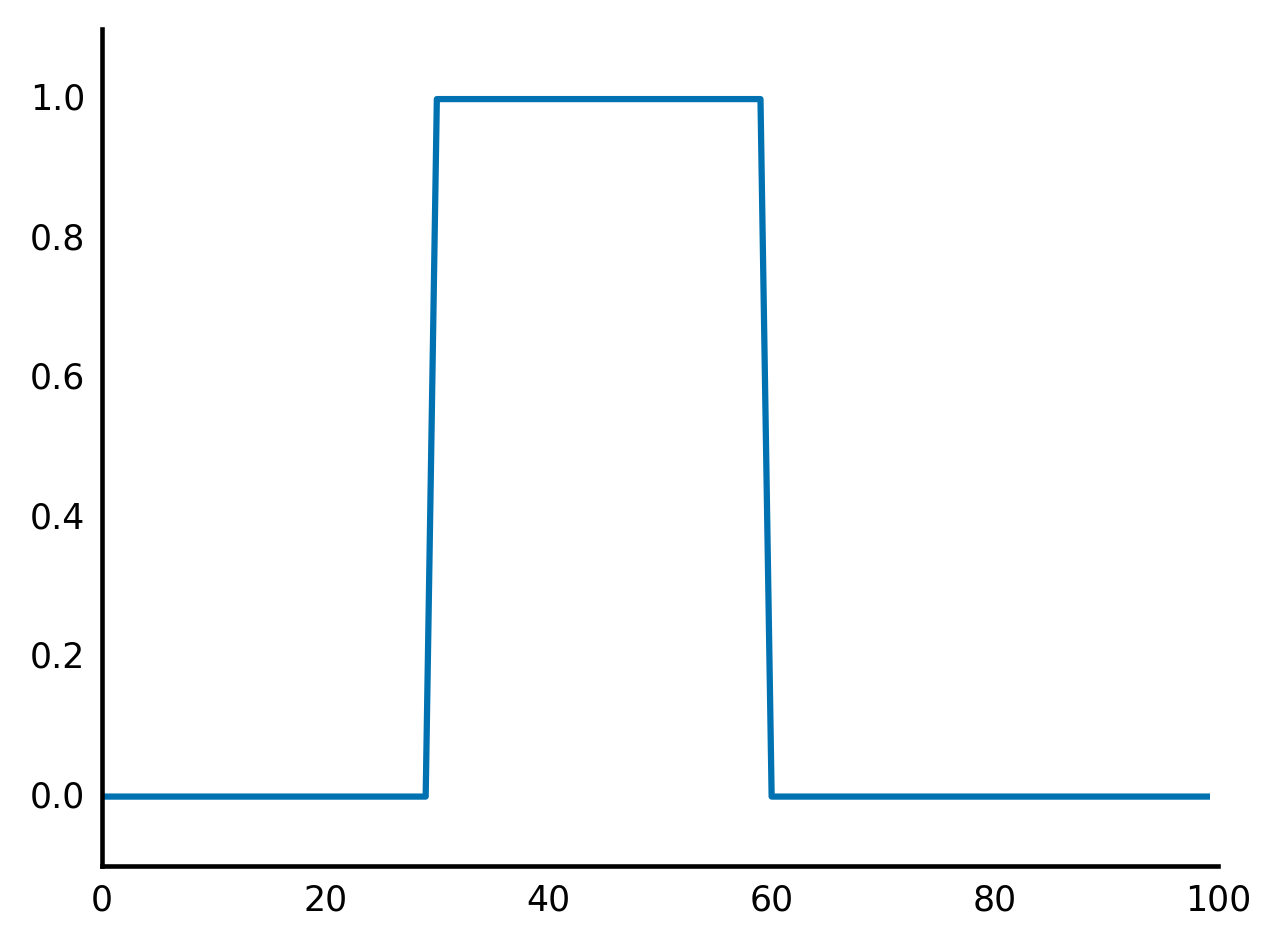

In [35]:
# Signal that is turned on and 30 ms later turned off, with samplings once every ms:
sig = np.zeros(100, np.float)
sig[30:60] = 1
fig, ax = plt.subplots()
ax.plot(sig)
ax.set_ylim(-0.1, 1.1)

Signal on at: 30


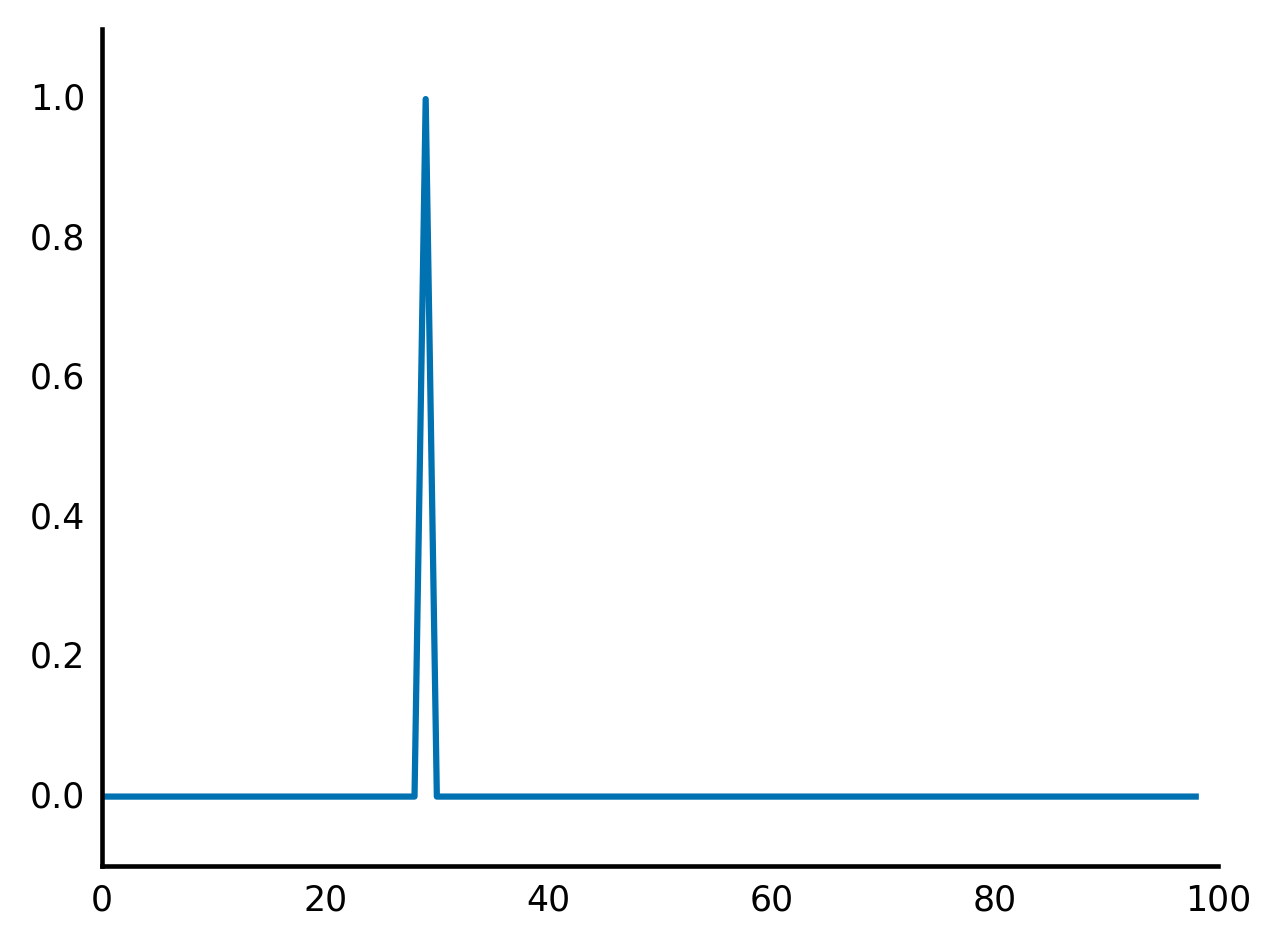

In [36]:
# To find when the light is turned on, can delay it by 1ms then subtract the original from the delayed signal.
# So when the signal is unchanged from one ms to the next, the subtraction will give zero. But when
# signal increases, will get a positive signal. When decreases, will get a negative signal.

# If only interested in pinpointing when light turned on, can clip the difference signal so that any
# neg value are converted to 0.
sigdelta = sig[1:]
sigdiff = sigdelta - sig[:-1]
sigon = np.clip(sigdiff, 0, np.inf)
fig, ax = plt.subplots()
ax.plot(sigon)
ax.set_ylim(-0.1, 1.1)
print("Signal on at: {}".format(1 + np.flatnonzero(sigon)[0], 'ms'))

# This is actually a form of CONVOLUTION. Depending on kernal given the convolution function, you can show
# a different feature of the signal.

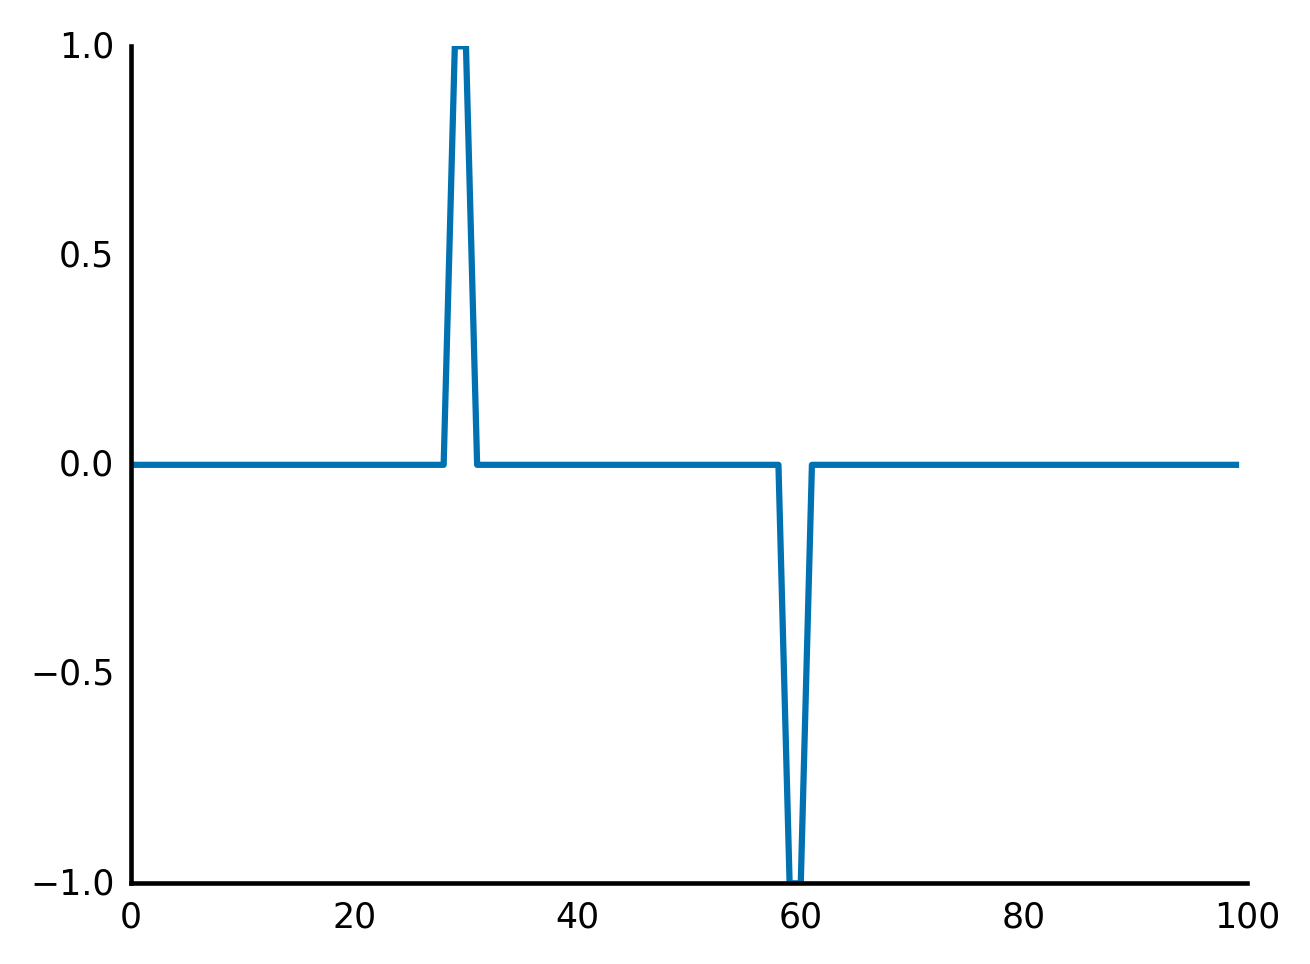

In [38]:
# Use the scipy convolve function

diff = np.array([1,0,-1])  # the difference filter
from scipy import ndimage as ndi
dsig = ndi.convolve(sig, diff)
plt.plot(dsig);

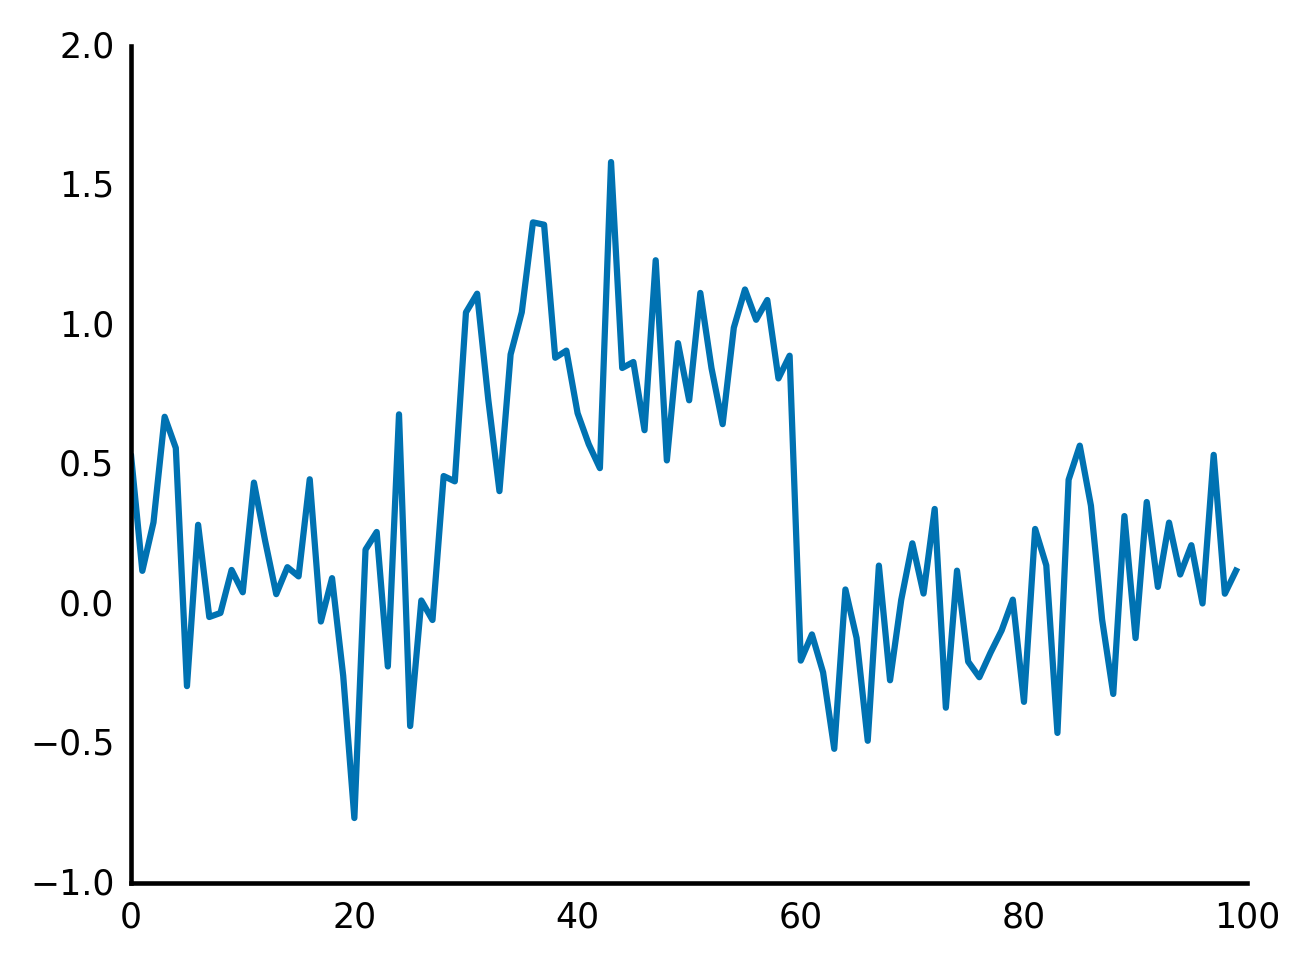

In [39]:
# Add noise to above signal

np.random.seed(0)
sig = sig + np.random.normal(0, 0.3, size=sig.shape)
plt.plot(sig);

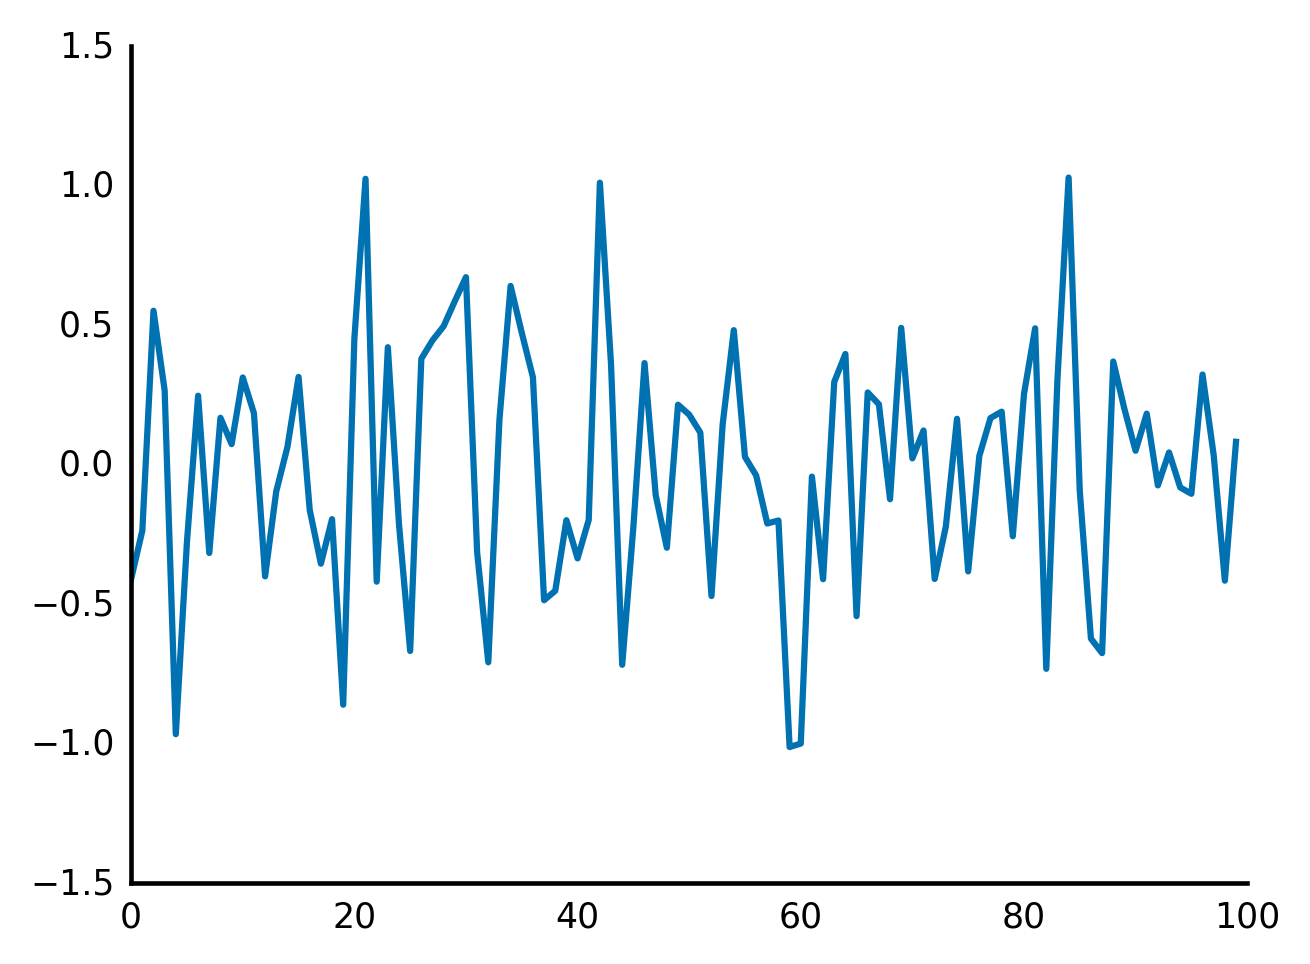

In [40]:
# plan difference filter can amplify the noise:
plt.plot(ndi.convolve(sig, diff));

In [41]:
# add Gaussian smoothing to the filter
def gaussian_kernel(size, sigma):
    """
    size needs to be 6 times greater than sigma to ensure sufficient coverage
    """
    
    positions = np.arange(size) - size // 2
    kernal_raw = np.exp(-positions**2 / (2*sigma**2))
    kernal_normalized = kernal_raw / np.sum(kernal_raw)
    return kernal_normalized

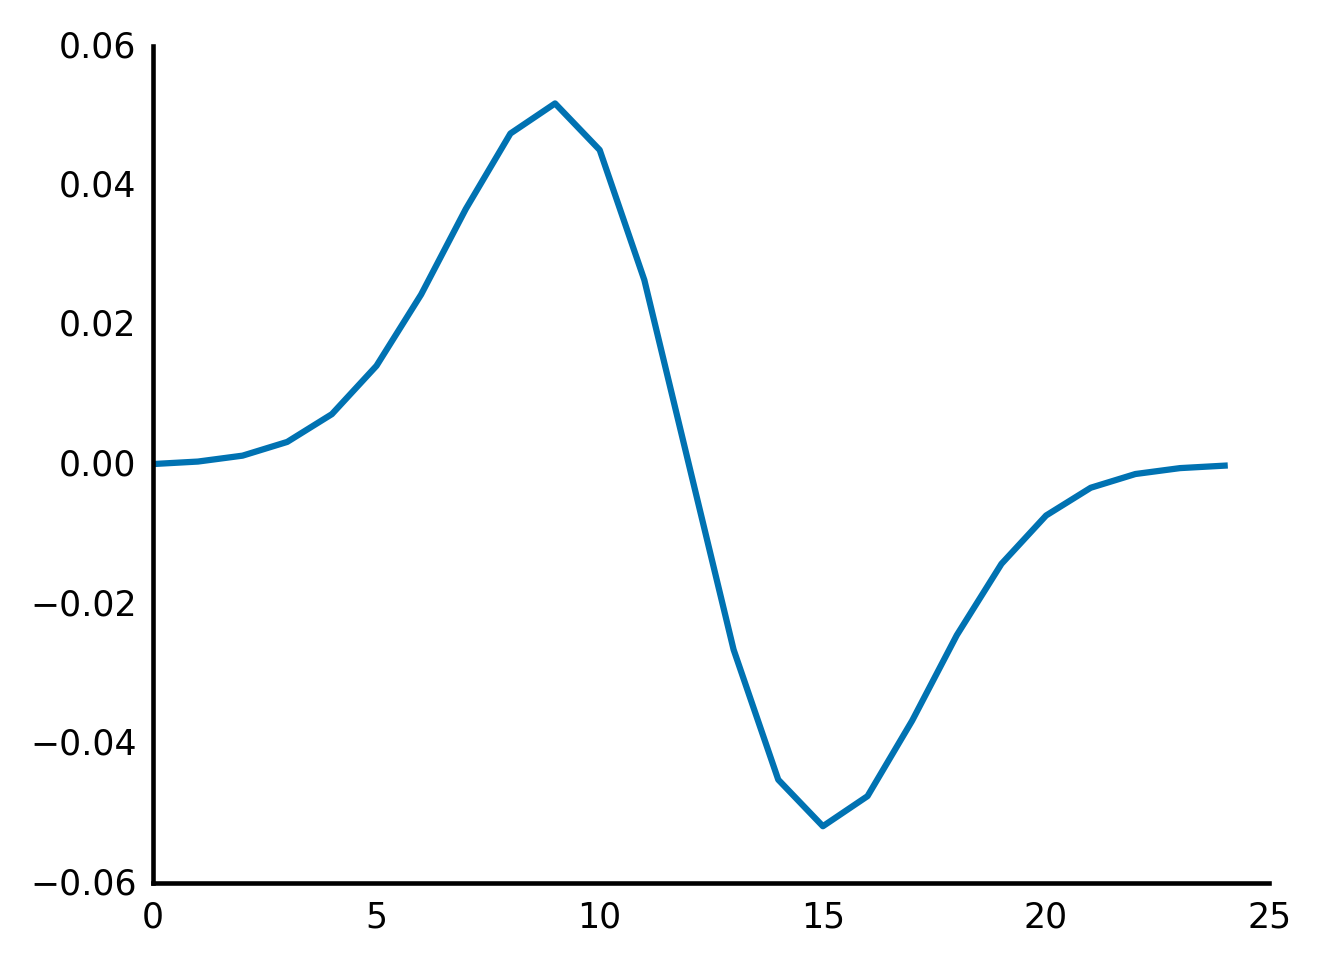

In [42]:
# can just smooth the filter, rather than data, and the smooth will be applied to the data via the filter, 
# saving computational time. (=associative)

smooth_diff = ndi.convolve(gaussian_kernel(25,3), diff)
plt.plot(smooth_diff);

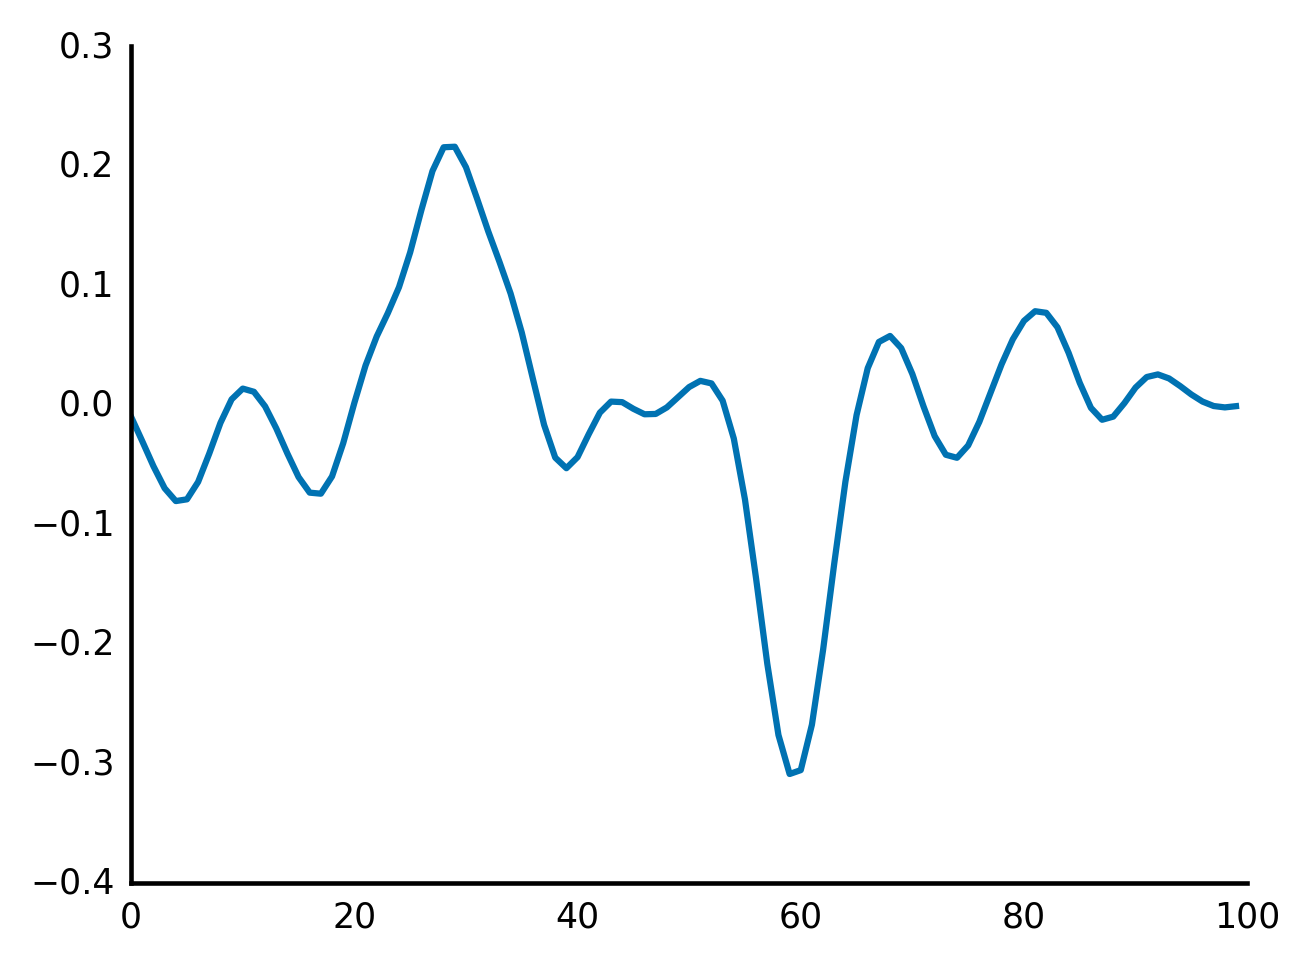

In [43]:
sdsig = ndi.convolve(sig, smooth_diff)
plt.plot(sdsig);

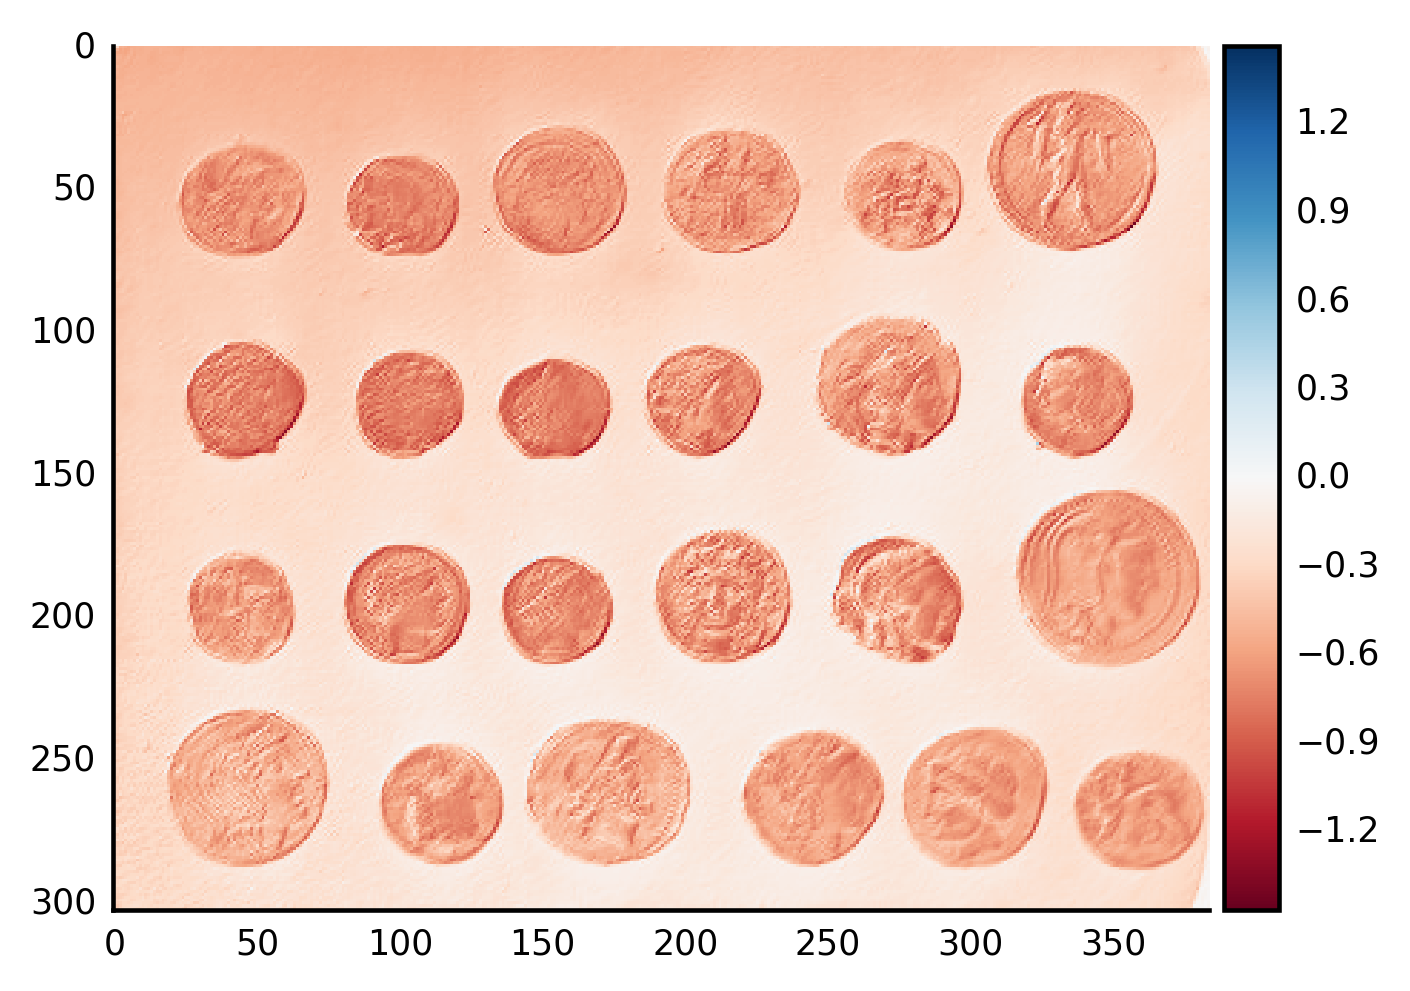

In [44]:
# Apply 2D difference filter to 2D image

coins = coins.astype(float) / 255 # to prevent overflow errors
diff2d = np.array([[0,1,-1], [0,-1,0]])
coins_edges = ndi.convolve(coins, diff2d)
io.imshow(coins_edges);

In [45]:
# can smooth out noise with a Sobel filter

# use column vector (vertical) to find horizontal edges
hdiff = np.array([[1], [0], [-1]])

In [46]:
hsobel = np.array([[1,2,1], [0,0,0], [-1,-2,-1]])
vsobel = hsobel.T # vertical sobel is transpose of horizontal

In [49]:
def reduce_xaxis_labels(ax, factor):
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)
    for label in ax.xaxis.get_ticklabels()[::factor]:
        label.set_visible(True)

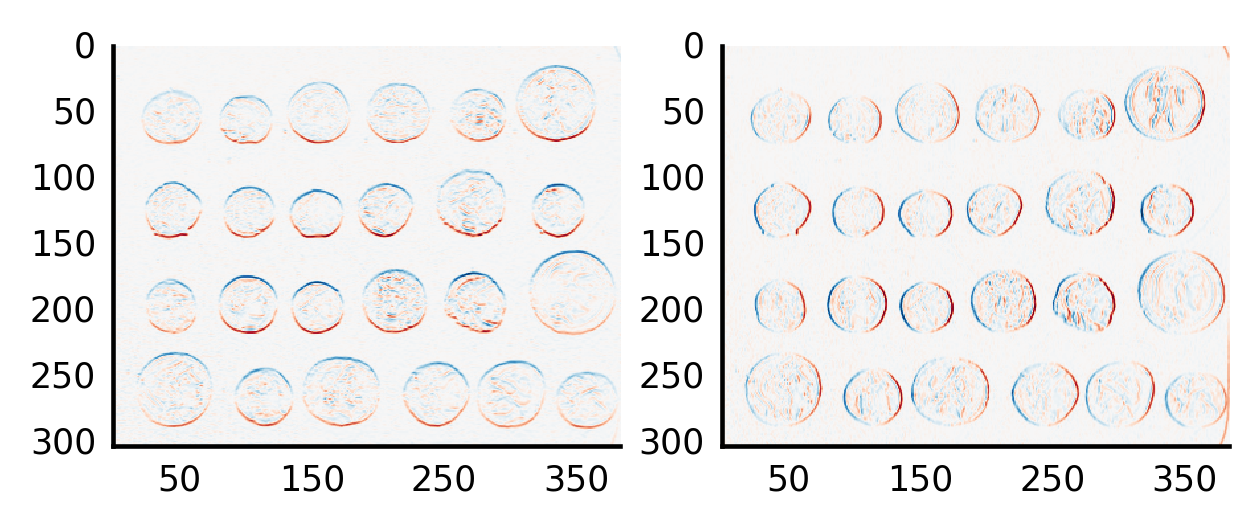

In [51]:
coins_h = ndi.convolve(coins, hsobel)
coins_v = ndi.convolve(coins, vsobel)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(coins_h, cmap=plt.cm.RdBu)
axes[1].imshow(coins_v, cmap=plt.cm.RdBu)
for ax in axes:
    reduce_xaxis_labels(ax, 2)

# Show both vertical and horizontal Sobel seperately

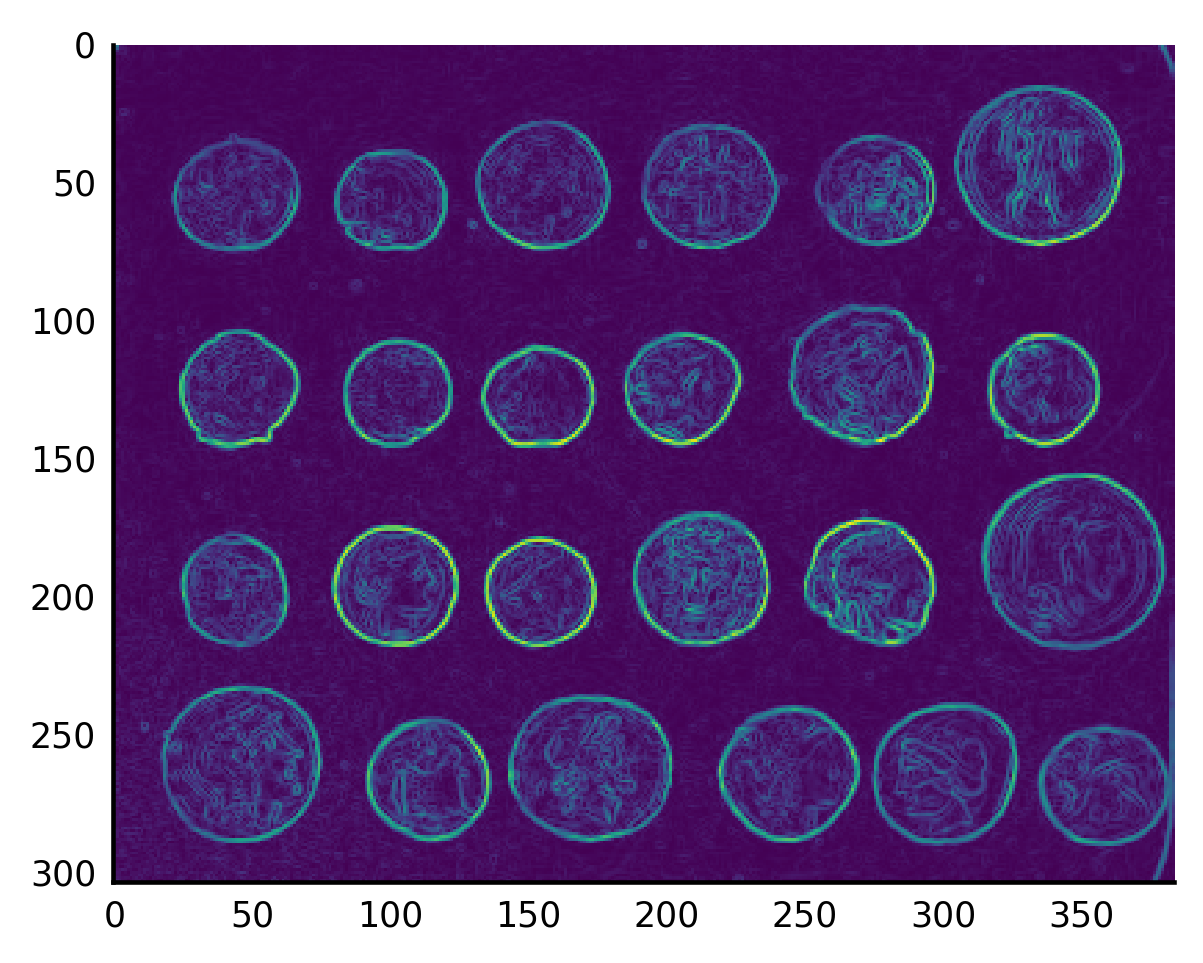

In [52]:
# the edge magnitude in any direction is equal to the square root of the sum of squares of the horizontal
# and vertical components

coins_sobel = np.sqrt(coins_h**2 + coins_v**2)
plt.imshow(coins_sobel, cmap='viridis');

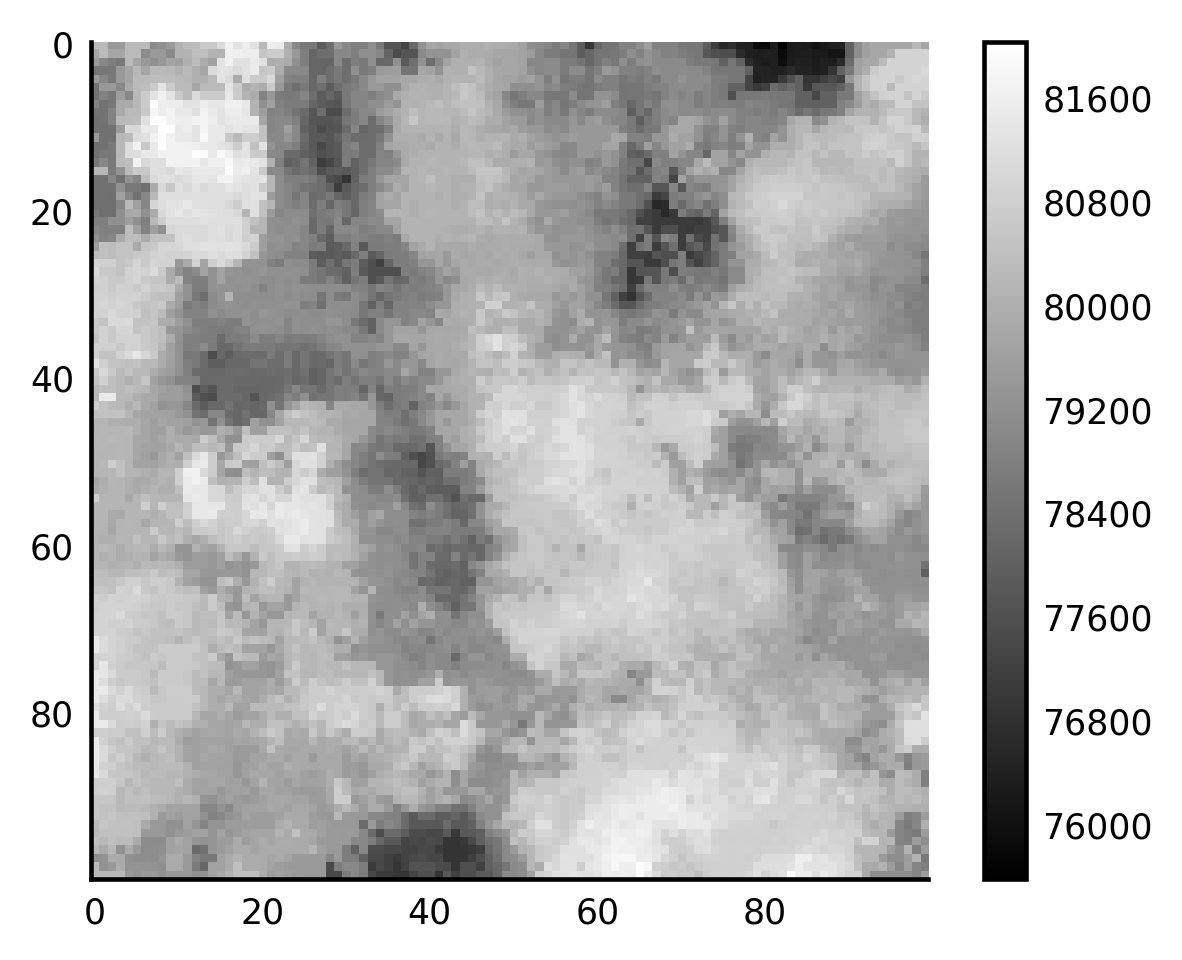

In [54]:
# in SciPy can define a filter that is an arbitrary function of the points in a neighborhood, implemented
# in ndi.generic_filter

# For example, map the sales tax rate of a community where 10,000 plus 5% of 90th percentile of house prices
# in 1km radius

from skimage import morphology

def tax(prices):
    return 10000 + 0.05 * np.percentile(prices, 90)
house_price_map = (0.5 + np.random.rand(100,100)) * 1e6
footprint = morphology.disk(radius=10)
tax_rate_map = ndi.generic_filter(house_price_map, tax, footprint=footprint)
plt.imshow(tax_rate_map)
plt.colorbar();

In [4]:
# Look at networks "graphs".
# Use the worm neuronal dataset
import pandas as pd
connectome_url = 'http://www.wormatlas.org/images/NeuronConnect.xls'
conn = pd.read_excel(connectome_url)

In [6]:
conn_edges = [(n1, n2, {'weight':s})
             for n1, n2, t, s in conn.itertuples(index=False, name=None)
             if t.startswith('S')]

In [7]:
# build the graph
import networkx as nx
wormbrain = nx.DiGraph()
wormbrain.add_edges_from(conn_edges)

In [10]:
# find the nodes that are "central hubs"
centrality = nx.betweenness_centrality(wormbrain)
central = sorted(centrality, key=centrality.get, reverse=True)
print(central[:5])

['AVAR', 'AVAL', 'PVCR', 'PVT', 'PVCL']


In [11]:
# Get the most strongly connected node
sccs = nx.strongly_connected_component_subgraphs(wormbrain)
giantscc = max(sccs, key=len)
print("The largest strongly connected component has {} nodes out of {} total".format(giantscc.number_of_nodes(), wormbrain.number_of_nodes()))

The largest strongly connected component has 237 nodes out of 279 total


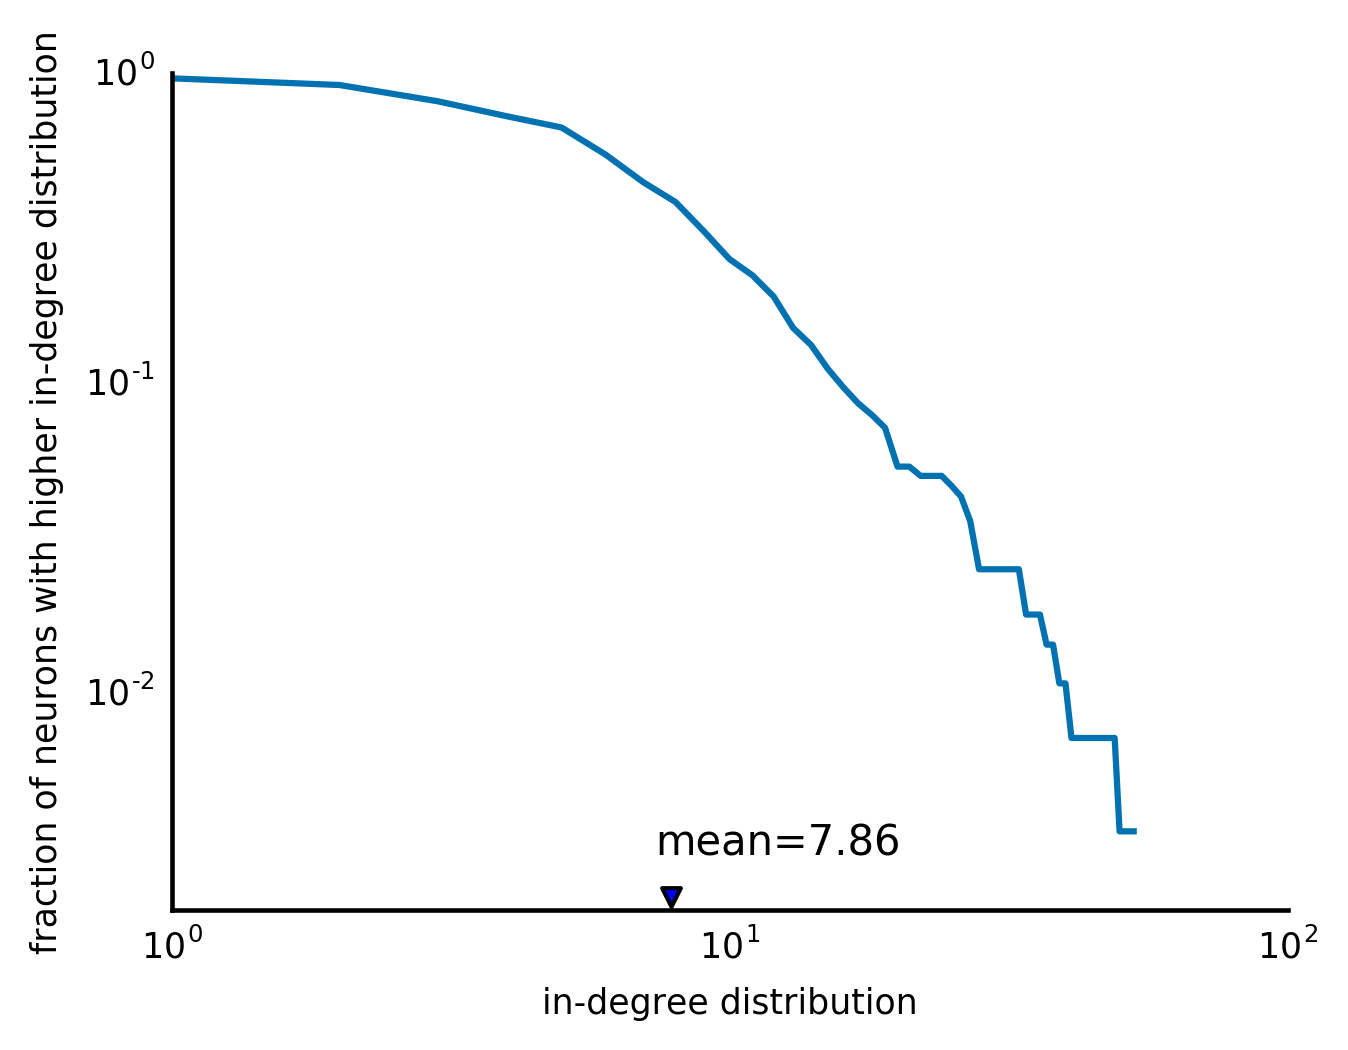

In [12]:
in_degrees = list(wormbrain.in_degree().values())
in_deg_distrib = np.bincount(in_degrees)
avg_in_degree = np.mean(in_degrees)
cumfreq = np.cumsum(in_deg_distrib) / np.sum(in_deg_distrib)
survival = 1 - cumfreq

fig, ax = plt.subplots()
ax.loglog(np.arange(1, len(survival)+1), survival)
ax.set_xlabel('in-degree distribution')
ax.set_ylabel('fraction of neurons with higher in-degree distribution')
ax.scatter(avg_in_degree, 0.0022, marker='v')
ax.text(avg_in_degree - 0.5, 0.003, 'mean=%.2f'%avg_in_degree)
ax.set_ylim(0.002, 1.0);

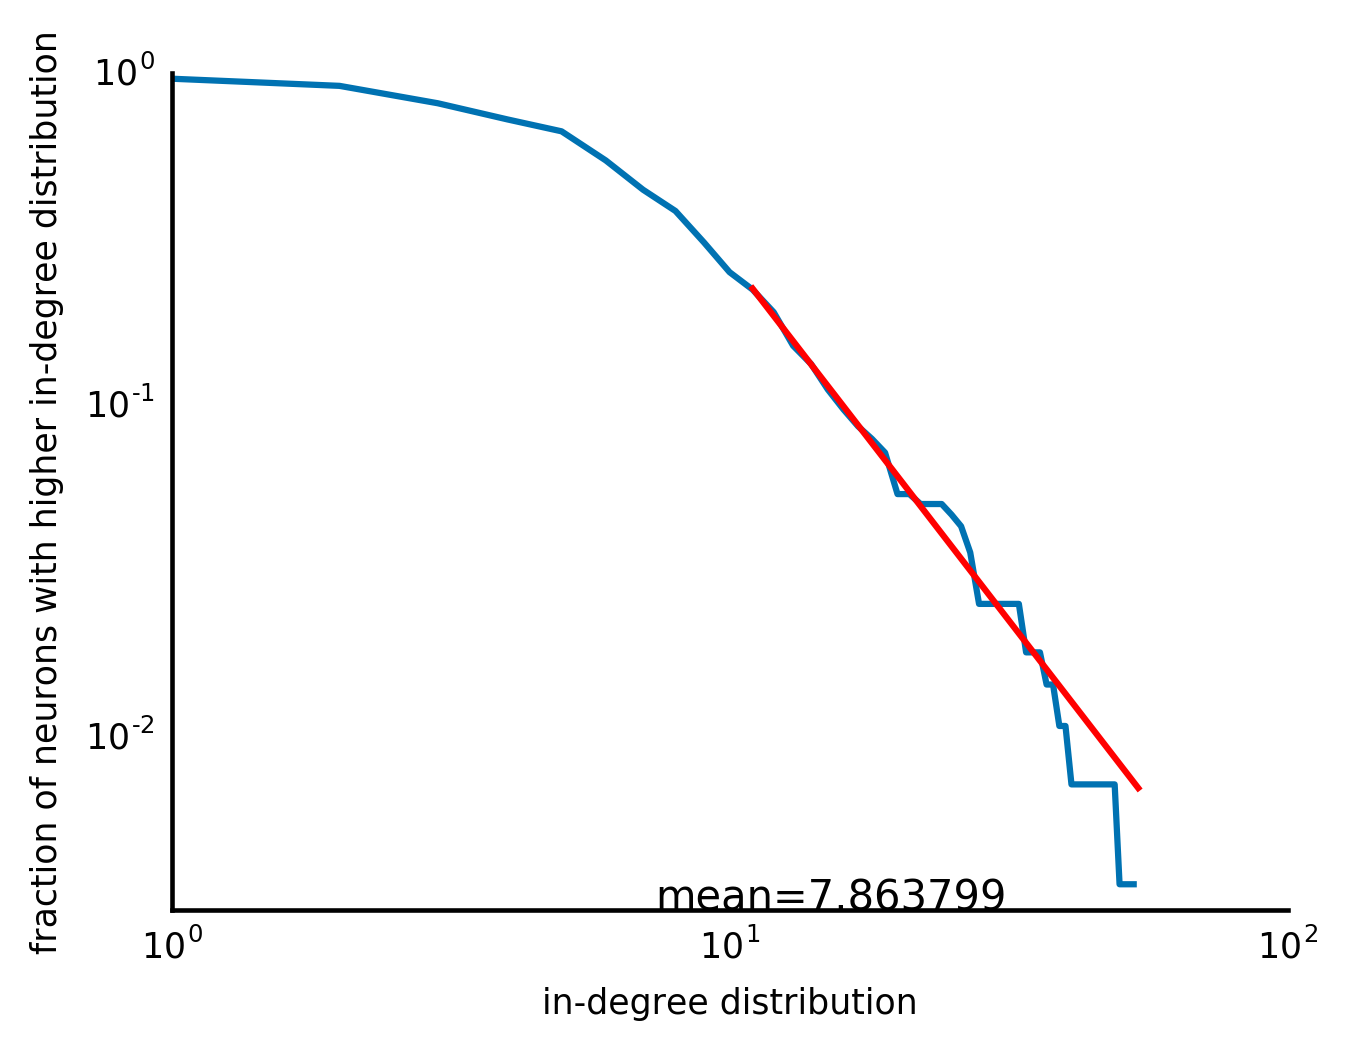

In [13]:
# Fit a power law.
def fraction_higher(degree, alpha, gamma):
    return alpha * degree**(-gamma)

x = 1 + np.arange(len(survival))
valid = x > 10
x = x[valid]
y = survival[valid]

from scipy.optimize import curve_fit
alpha_fit, gamma_fit = curve_fit(fraction_higher, x, y)[0]

y_fit = fraction_higher(x, alpha_fit, gamma_fit)

fig, ax = plt.subplots()
ax.loglog(np.arange(1, len(survival)+1), survival)
ax.set_xlabel('in-degree distribution')
ax.set_ylabel('fraction of neurons with higher in-degree distribution')
ax.scatter(avg_in_degree, 0.0022, marker='v')
ax.text(avg_in_degree - 0.5, 0.003, 'mean=%f'% avg_in_degree)
ax.set_ylim(0.003, 1.0)
ax.loglog(x, y_fit, c='red')

In [14]:
# now to play with segmenting images

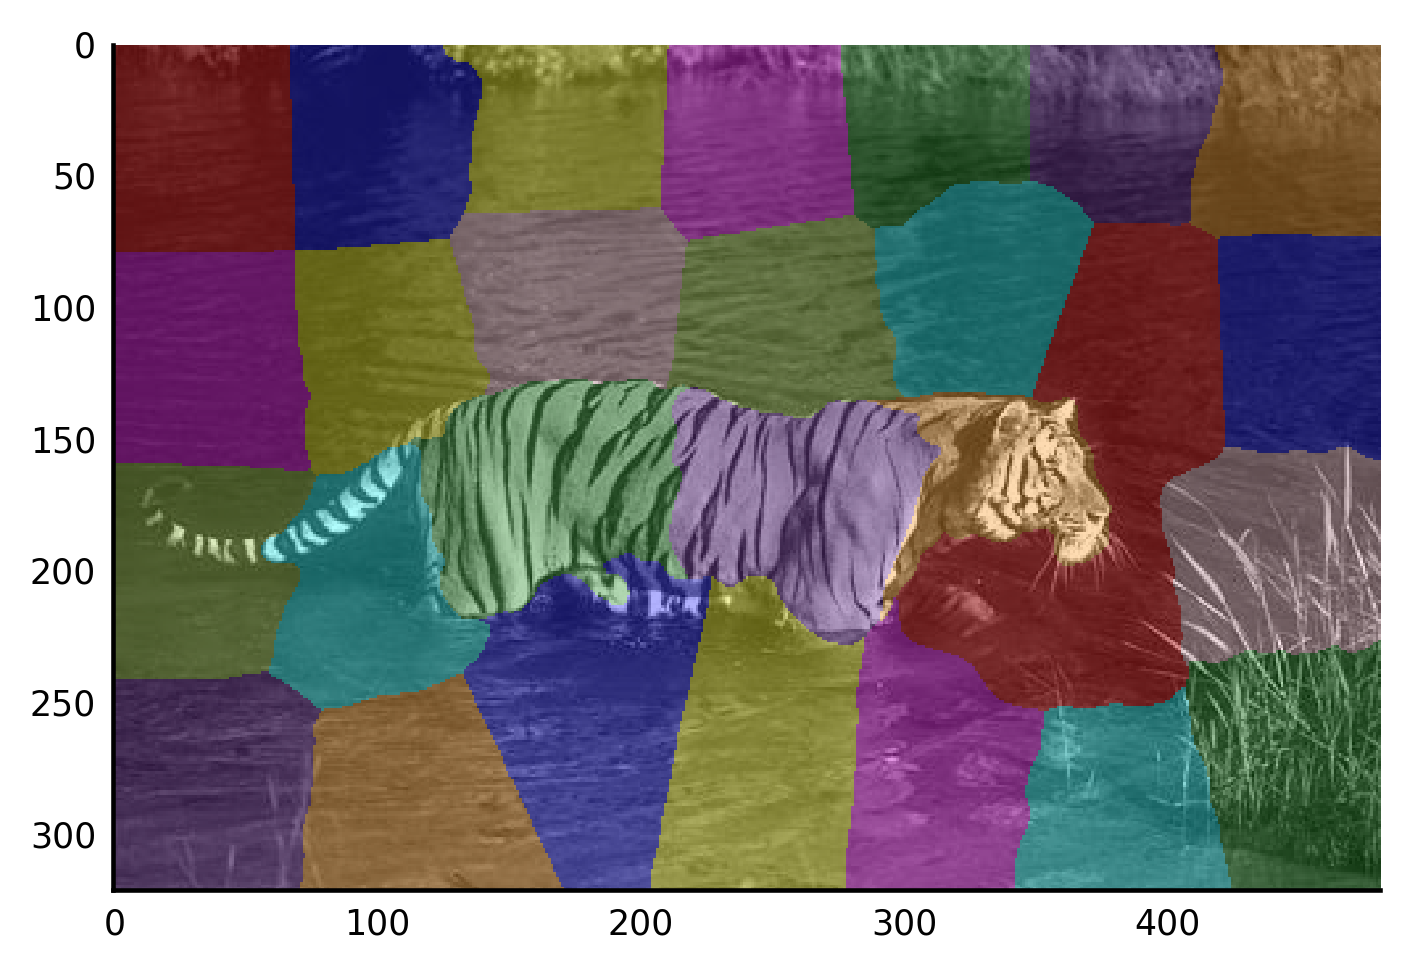

In [5]:
# A clustering algorithm, simpel linear iterative clustering (SLIC) is a decent starting point
import skimage
from skimage import io

url = ('https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300/html/images/plain/normal/color/108073.jpg')
tiger = io.imread(url)
from skimage import segmentation
seg = segmentation.slic(tiger, n_segments=30, compactness=40.0, enforce_connectivity=True, sigma=3)

from skimage import color
io.imshow(color.label2rgb(seg, tiger))

In [9]:
# Write routine to take tiger out of image.
# Most obvious approach is a nested for loop to iterate over every pizel, look at neighboring
# pixels and check for different labels:

import networkx as nx
def build_rag(labels, image):
    g = nx.Graph()
    nrows, ncols = labels.shape
    
    for row in range(nrows):
        for col in range(ncols):
            current_label = labels[row, col]
            if not current_label in g:
                g.add_node(current_label)
                g.node[current_label]['total color'] = np.zeros(3,dtype=np.float)
                g.node[current_label]['pixel count'] = 0
            if row < nrows - 1 and labels[row+1, col] != current_label:
                g.add_edge(current_label, labels[row+1, col])
            if col < ncols - 1 and labels[row, col+1] != current_label:
                g.add_edge(current_label, labels[row, col+1])
            g.node[current_label]['total color'] += image[row, col]
            g.node[current_label]['pixel count'] += 1
    return g

In [15]:
# Can do this more elegantly with SciPy's `generic_filter`. 
import networkx as nx
import numpy as np
from scipy import ndimage as ndi

def add_edge_filter(values, graph):
    center = values[len(values) // 2]
    for neighbor in values:
        if neighbor != center and not graph.has_edge(center, neighbor):
            graph.add_edge(center, neighbor)
    #  float return value is unused but needed by `generic_filter`
    return 0.0

def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint, 
                          mode='nearest', extra_arguments=(g,))
    for n in g:
        g.node[n]['total color'] = np.zeros(3, np.double)
        g.node[n]['pixel count'] = 0
    for index in np.ndindex(labels.shape):
        n = labels[index]
        g.node[n]['total color'] += image[index]
        g.node[n]['pixel count'] += 1
    return g

In [16]:
# Now segment the the tiger
g = build_rag(seg, tiger)
for n in g:
    node = g.node[n]
    node['mean'] = node['total color'] / node['pixel count']
for u, v in g.edges_iter():
    d = g.node[u]['mean'] - g.node[v]['mean']
    g[u][v]['weight'] = np.linalg.norm(d)
    

In [17]:
def threshold_graph(g, t):
    to_remove = ((u,v) for (u,v,d) in g.edges(data=True) if d['weight'] > t)
    g.remove_edges_from(to_remove)
    
threshold_graph(g, 80)

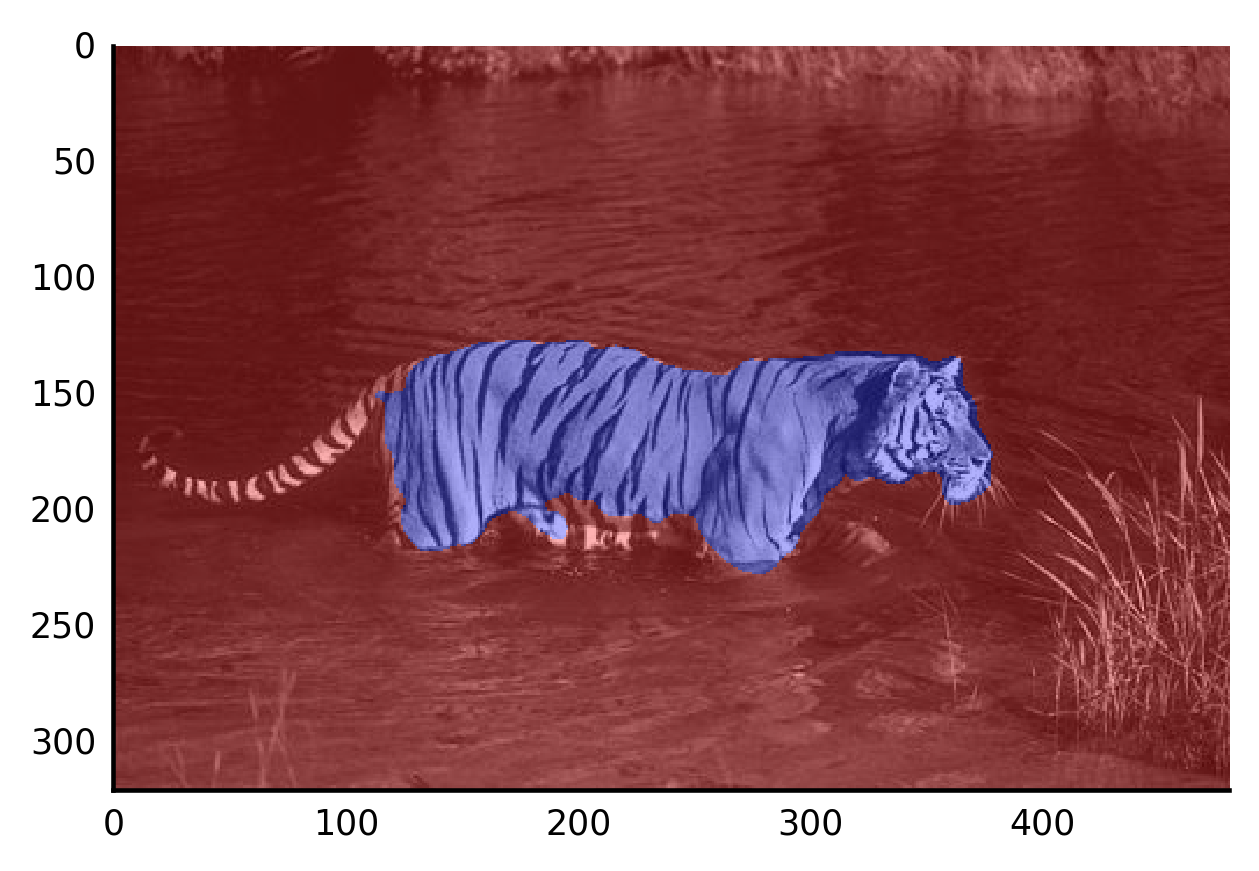

In [18]:
map_array = np.zeros(np.max(seg) + 1, int)
for i, segment in enumerate(nx.connected_components(g)):
    for initial in segment:
        map_array[int(initial)] = i
segmented = map_array[seg]
plt.imshow(color.label2rgb(segmented, tiger));